In [1]:
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
import os
import unicodedata
import pickle
import numpy as np
from pprint import pprint

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None

In [2]:
df = pd.read_parquet("../data/iugu.parquet", engine="pyarrow")
df["html"] = df["html"].astype(str)
df["raiz_cnpj"] = df["raiz_cnpj"].astype(int)
df.head(5)

,url,host,html,date,raiz_cnpj,cnpj,Nome da empresa,Nicho Tech,Segmento iugu
0,http://olaisaac.com.br,olaisaac.com.br,b'<!DOCTYPE html><!-- This site was created in...,2025-04-29T16:13:39.313892,38008510,38008510000188,ISAAC,Edtechs,Educação
1,http://www.uoon.com.br,uoon.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n\n<hea...",2025-04-29T16:13:39.623408,34251650,34251650000121,UOON,Healthtech,Saúde
2,https://biologix.com.br,biologix.com.br,"b'<!doctype html>\n<html dir=""ltr"" lang=""pt-BR...",2025-04-29T16:13:41.753382,21892103,21892103000183,BIOLOGIX SISTEMAS LTDA,Healthtech,Saúde
3,https://timedesaude.com.br,timedesaude.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-br"">\n<head>...",2025-04-29T16:13:39.687784,34266553,34266553000102,ALICE OPERADORA LTDA,Healthtech,Saúde
4,https://psicomanager.com.br,psicomanager.com.br,"b'<!DOCTYPE html><html id=""__next_error__""><he...",2025-04-29T16:13:39.895817,29983313,29983313000199,PSICO GESTOR TECNOLOGIA LTDA,Healthtech,Saúde


In [3]:
df.shape

(18, 9)

In [4]:
linkedin_normalizado = pd.read_csv("/media/greca/HD/Driva/linkedin_normalizado_202505021514.csv")
linkedin_normalizado.head(5)

/tmp/ipykernel_12182/700681916.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  linkedin_normalizado = pd.read_csv("/media/greca/HD/Driva/linkedin_normalizado_202505021514.csv")


,company_id,url,raiz_cnpj,sobre,faixa_funcionarios,crunchbase_url,qtde_funcionarios_linkedin,qtde_seguidores,localizacao_sede,industrias,localizacoes,logo,nome_empresa,empresas_similares,slogan,especialidades,area_atuacao,timestamp,dominio,origem_dados,possui_investidores,cep_sede,pagina_generica
0,euliricas,linkedin.com/company/euliricas,20613713,"tocar o mundo, poema a poema. artes e poemas d...",2-10,NaN,3.0,42.0,"Rua Harmonia, 218 - B -",Retail,NaN,https://media.licdn.com/dms/image/C4D1BAQEyDZN...,Eulíricas,NaN,"onde puder, poesia.",NaN,Retail,2024-07-12,euliricas.com.br,BASE,NaN,5435000,False
1,aajuc,linkedin.com/company/aajuc,13503218,Aajuc is a civic & social organization company...,-,NaN,3.0,2.0,-,Civic and Social Organizations,NaN,NaN,Aajuc,NaN,NaN,NaN,Civic and Social Organizations,2024-07-10,aajuc.com.br,BASE,NaN,NaN,True
2,tiradentes-viagens-e-turismo,linkedin.com/company/tiradentes-viagens-e-turismo,3656149,NaN,11-50,NaN,1.0,4.0,"SAO JOAO DEL REI, MINAS GERAIS",NaN,"{""AVENIDA TIRADENTES 600, SAO JOAO DEL REI, MI...",https://static-exp1.licdn.com/sc/h/cs8pjfgyw96...,TIRADENTES VIAGENS E TURISMO,NaN,NaN,NaN,NaN,2022-01-09,NaN,BASE,False,36307-348,True
3,montjuïc-espaço-intimista,linkedin.com/company/montju%C3%AFc-espa%C3%A7o...,28389082,Montjuïc Espaço Intimista is an individual & f...,-,NaN,3.0,2.0,-,Individual and Family Services,NaN,NaN,Montjuïc Espaço Intimista,NaN,NaN,NaN,Individual and Family Services,2024-07-11,espacomontjuic.com,BASE,NaN,NaN,True
4,dataconta-tecnologia,linkedin.com/company/dataconta-tecnologia,30102756,Dataconta Tecnologia is a facilities services ...,-,NaN,0.0,0.0,-,Facilities Services,NaN,NaN,Dataconta Tecnologia,NaN,NaN,NaN,Facilities Services,2024-07-11,dataconta.com,BASE,NaN,NaN,True


In [5]:
df = df.merge(linkedin_normalizado, on="raiz_cnpj", how="left")
df = df[["url_x", "host", "html", "raiz_cnpj", "cnpj", "Nome da empresa", "Nicho Tech", "Segmento iugu", "url_y", "sobre", "slogan", "area_atuacao"]]
df = df.rename(columns={"url_x": "url", "url_y": "linkedin_url"})
df

,url,host,html,raiz_cnpj,cnpj,Nome da empresa,Nicho Tech,Segmento iugu,linkedin_url,sobre,slogan,area_atuacao
0,http://olaisaac.com.br,olaisaac.com.br,b'<!DOCTYPE html><!-- This site was created in...,38008510,38008510000188,ISAAC,Edtechs,Educação,linkedin.com/company/isaaceducacao,O isaac é a maior plataforma de soluções finan...,A maior plataforma de soluções financeiras fei...,Financial Services
1,http://www.uoon.com.br,uoon.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n\n<hea...",34251650,34251650000121,UOON,Healthtech,Saúde,linkedin.com/company/uoon-content-creator,UOON E UMA PLATAFORMA DIGITAL DESENVOLVIDA POR...,SOMOS A PLATAFORMA DIGITAL QUE VEIO TRANSFORMA...,PHOTOGRAPHY
2,https://biologix.com.br,biologix.com.br,"b'<!doctype html>\n<html dir=""ltr"" lang=""pt-BR...",21892103,21892103000183,BIOLOGIX SISTEMAS LTDA,Healthtech,Saúde,linkedin.com/company/biologix,O Exame do Sono Biologix é um exame de apneia ...,Saúde do sono na ponta do dedo,Medical Equipment Manufacturing
3,https://timedesaude.com.br,timedesaude.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-br"">\n<head>...",34266553,34266553000102,ALICE OPERADORA LTDA,Healthtech,Saúde,NaN,NaN,NaN,NaN
4,https://psicomanager.com.br,psicomanager.com.br,"b'<!DOCTYPE html><html id=""__next_error__""><he...",29983313,29983313000199,PSICO GESTOR TECNOLOGIA LTDA,Healthtech,Saúde,NaN,NaN,NaN,NaN
5,https://lastlink.com,lastlink.com,b'<!DOCTYPE html><!-- Last Published: Tue Jan ...,38220040,38220040000111,LASTLINK,Edtechs,Educação,linkedin.com/company/lastlink-oficial,JA PAROU PARA PENSAR QUE DENTRO DA SUA REDE DE...,EXPLORE SUAS POSSIBILIDADES DE VENDER MAIS,"TECHNOLOGY, INFORMATION AND INTERNET"
6,http://www.themembers.com.br,themembers.com.br,"b'<!DOCTYPE html><html lang=""pt-BR""><head><scr...",41160388,41160388000175,THE MEMBERS,Edtechs,Educação,NaN,NaN,NaN,NaN
7,http://pagmex.com,pagmex.com,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>...",52835814,52835814000140,PAGMEX SOLUCOES DE PAGAMENTOS LTDA,Fintechs,Saas,NaN,NaN,NaN,NaN
8,https://www.suno.com.br,suno.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n\n<hea...",26228525,26228525000172,SUNO RESEARCH,Edtechs,Educação,NaN,NaN,NaN,NaN
9,https://www.greenn.com.br,greenn.com.br,b'<!doctype html>\n<html data-n-head-ssr lang=...,31975959,31975959000176,GREENN PAGAMENTOS E TECNOLOGIA LTDA,Edtechs,Educação,NaN,NaN,NaN,NaN


In [6]:
df.shape

(18, 12)

In [7]:
df['host'].nunique()

18

In [8]:
df['Segmento iugu'].value_counts()

Segmento iugu
Educação    10
Saúde        4
Saas         4
Name: count, dtype: int64

In [9]:
df['Nicho Tech'].value_counts()

Nicho Tech
Edtechs       10
Healthtech     4
Fintechs       4
Name: count, dtype: int64

In [10]:
df.isnull().sum()

url                 0
host                0
html                0
raiz_cnpj           0
cnpj                0
Nome da empresa     0
Nicho Tech          0
Segmento iugu       0
linkedin_url       11
sobre              11
slogan             11
area_atuacao       11
dtype: int64

In [11]:
df = df[["host", "url", "html", "sobre", "slogan", "Segmento iugu"]]
df = df.rename(columns={"Segmento iugu": "segment", "sobre": "about"})
df.head()

,host,url,html,about,slogan,segment
0,olaisaac.com.br,http://olaisaac.com.br,b'<!DOCTYPE html><!-- This site was created in...,O isaac é a maior plataforma de soluções finan...,A maior plataforma de soluções financeiras fei...,Educação
1,uoon.com.br,http://www.uoon.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n\n<hea...",UOON E UMA PLATAFORMA DIGITAL DESENVOLVIDA POR...,SOMOS A PLATAFORMA DIGITAL QUE VEIO TRANSFORMA...,Saúde
2,biologix.com.br,https://biologix.com.br,"b'<!doctype html>\n<html dir=""ltr"" lang=""pt-BR...",O Exame do Sono Biologix é um exame de apneia ...,Saúde do sono na ponta do dedo,Saúde
3,timedesaude.com.br,https://timedesaude.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-br"">\n<head>...",NaN,NaN,Saúde
4,psicomanager.com.br,https://psicomanager.com.br,"b'<!DOCTYPE html><html id=""__next_error__""><he...",NaN,NaN,Saúde


# Feature Engineering

In [12]:
def check_integrity(dataframe):
    try:
        columns_expected = [
            'host',
            'html',
            'url',
        ]
        
        if not all(item in dataframe.columns.tolist() for item in columns_expected):
            raise Exception('Missing required columns. Columns expected:\n' + str(columns_expected))
        
        dataframe['html'] = dataframe['html'].astype(str)

        dataframe_filtered = dataframe[(dataframe['html'] != '[]') & 
                                (dataframe['html'] != '')]
    
        if len(dataframe) != len(dataframe_filtered):
            count = len(dataframe) - len(dataframe_filtered)
            print(f"WARNING: dataframe has {count} entries with empty HTML and/or does not ends with '.br'. Removing those entries.")
            dataframe = dataframe_filtered

        dataframe_filtered = dataframe.drop_duplicates(subset=["host"])
        if len(dataframe) != len(dataframe_filtered):
            count = len(dataframe) - len(dataframe_filtered)
            print(f"WARNING: dataframe has {count} entries with duplicates values. Removing those entries.")
            dataframe = dataframe_filtered
    
        nulls = dataframe['host'].isnull().sum()
        if nulls > 0:
            print(f"WARNING: column 'host' has {nulls} empty values. Removing those entries.")
            dataframe = dataframe.dropna(subset=['host'])

        nulls = dataframe['url'].isnull().sum()
        if nulls > 0:
            print(f"WARNING: column 'url' has {nulls} empty values. Removing those entries.")
            dataframe = dataframe.dropna(subset=['url'])

        nulls = dataframe['html'].isnull().sum()
        if nulls > 0:
            print(f"WARNING: column 'html' has {nulls} empty values. Removing those entries.")
            dataframe = dataframe.dropna(subset=['html'])
        
        return dataframe
    except Exception as e:
        raise Exception('Failed in integrity check.\nError:\n' + str(e))

In [13]:
def build_lemmatizer_pt_dict():
    try:
        import os
        import requests
        
        url = "https://github.com/michmech/lemmatization-lists/raw/master/lemmatization-pt.txt"
        file_name = "lemmatization-pt.txt"

        # Verificar se o arquivo já existe
        if not os.path.exists(file_name):
            response = requests.get(url)
            with open(file_name, 'wb') as f:
                f.write(response.content)

        # Processar o arquivo
        lemmatizer_pt_dict = {}
        with open(file_name, 'r') as dic:
            for line in dic:
                txt = line.split()
                if len(txt) == 2:
                    lemmatizer_pt_dict[txt[1]] = txt[0]

        return lemmatizer_pt_dict
    except Exception as e:
        file_name = "lemmatization-pt.txt"
        if os.path.exists(file_name):
            os.remove(file_name)
        raise Exception('An error occurred on custom_lemmatizer.\nError:\n' + str(e))

    finally:
        file_name = "lemmatization-pt.txt"
        if os.path.exists(file_name):
            os.remove(file_name)


In [14]:
def custom_lemmatizer(tokens, lemmatizer_pt_dict):
    try:
      from nltk.stem.wordnet import WordNetLemmatizer
  
      lemmatizer = WordNetLemmatizer()
      tokens_lemmatized = []
      for token in tokens:
        if token in lemmatizer_pt_dict.keys():
          tokens_lemmatized.append(lemmatizer_pt_dict.get(token))
        else:
          tokens_lemmatized.append(lemmatizer.lemmatize(token))

      return tokens_lemmatized
    except Exception as e:
        raise Exception('An error occurred on custom_lemmatizer.\nError:\n' + str(e))

In [15]:
def process_html_for_vectorizer(text, lemmatizer_pt_dict):
    import nltk
    from nltk.corpus import stopwords
    import unicodedata
    from bs4 import BeautifulSoup
    import re
    
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)

    try:              
        STOP_WORDS = (set(stopwords.words('portuguese'))).union(set(stopwords.words('english')))

        preprocessed_text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

        # Remover espaços em branco e quebras de linha desnecessárias
        preprocessed_text = re.sub(r'\s+', ' ', preprocessed_text).strip()

        # substitui tudo que não é letra ou espaço por um espaço
        preprocessed_text = re.sub(r"[^a-zA-Z\s]", " ", preprocessed_text)

        # Regex para identificar palavras
        pattern = re.compile(r'([A-Z]+(?![a-z])|[A-Z][a-z]*|[a-z]+)')

        # Substituir as correspondências por elas mesmas precedidas por um espaço
        preprocessed_text = pattern.sub(r' \1', preprocessed_text)

        # lowercase
        preprocessed_text = preprocessed_text.lower()

        # remover possives espaços repetidos
        preprocessed_text = re.sub(r"\s+", " ", preprocessed_text).strip()

        # tokenizar
        tokens = nltk.word_tokenize(preprocessed_text)

        # remover stopwords
        tokens = [
            token for token in tokens if token not in STOP_WORDS and len(token) > 2
        ]

        # Aplicar lemmatizer
        tokens = custom_lemmatizer(tokens, lemmatizer_pt_dict)

        return tokens
    except Exception as e:
        raise Exception('An error occurred while processing HTMLs for vectorizer.\nError:\n' + str(e))

def process_extra_text(text, lemmatizer_pt_dict):
    import nltk
    from nltk.corpus import stopwords
    import unicodedata
    from bs4 import BeautifulSoup
    import re
    
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)

    if pd.isna(text):
        return []

    try:              
        STOP_WORDS = (set(stopwords.words('portuguese'))).union(set(stopwords.words('english')))

        preprocessed_text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

        # Remover espaços em branco e quebras de linha desnecessárias
        preprocessed_text = re.sub(r'\s+', ' ', preprocessed_text).strip()

        # substitui tudo que não é letra ou espaço por um espaço
        preprocessed_text = re.sub(r"[^a-zA-Z\s]", " ", preprocessed_text)

        # Regex para identificar palavras
        pattern = re.compile(r'([A-Z]+(?![a-z])|[A-Z][a-z]*|[a-z]+)')

        # Substituir as correspondências por elas mesmas precedidas por um espaço
        preprocessed_text = pattern.sub(r' \1', preprocessed_text)

        # lowercase
        preprocessed_text = preprocessed_text.lower()

        # remover possives espaços repetidos
        preprocessed_text = re.sub(r"\s+", " ", preprocessed_text).strip()

        # tokenizar
        tokens = nltk.word_tokenize(preprocessed_text)

        # remover stopwords
        tokens = [
            token for token in tokens if token not in STOP_WORDS and len(token) > 2
        ]

        # Aplicar lemmatizer
        tokens = custom_lemmatizer(tokens, lemmatizer_pt_dict)

        return tokens
    except Exception as e:
        raise Exception('An error occurred while processing HTMLs for vectorizer.\nError:\n' + str(e))

In [16]:
from bs4 import BeautifulSoup
import re

def process_html_for_how_many_prices(text):
    try:              
        regex_precos = re.compile(r'\$|R\$')
        precos = regex_precos.findall(text)
        return len(precos)
    except Exception as e:
        raise Exception('An error occurred while processing HTMLs for prices.\nError:\n' + str(e))

def process_html_for_how_many_values(text):
    try:              
        regex_valores = re.compile(r'\d+(?:\.\d{3})*(?:,\d{2})?|\d+(?:,\d{3})*(?:\.\d{2})?')
        valores = regex_valores.findall(text)
        return len(valores)
    except Exception as e:
        raise Exception('An error occurred while processing HTMLs for values.\nError:\n' + str(e))

def get_html_body(html_str):
    try:
        # Tentar usar diferentes parsers
        for parser in ['html.parser', 'html5lib', 'lxml']:
            try:
                soup = BeautifulSoup(html_str, parser)
                text = soup.body.get_text() if soup.body else ''
                return text
            except Exception as parser_e:
                continue
        
    except Exception as e:
        return ''

In [17]:
def only_number(text):
    text = re.sub(r'[^\d]', '', text)
    return text

def remove_invalid_company(company_id):
    company_id = re.sub(r'(\d)\1{12}', '', company_id)
    if len(company_id) == 14:
        return company_id
    return None 

def order_by_common(data):
    from collections import Counter
    data_output = Counter(data)
    return [k for k, v in data_output.most_common()]

def extract_and_process_cnpjs(text):
    pattern = re.compile(r'\d{2}\.\d{3}\.\d{3}[\/ ]\d{4}[- ]\d{2}')
    matches = pattern.findall(text)
    processed_matches = []
    for match in matches:
        cleaned = only_number(match)
        valid_company = remove_invalid_company(cleaned)
        if valid_company:
            processed_matches.append(valid_company)
    return processed_matches

In [18]:
def generate_features(dataframe):
    try:
        dataframe = check_integrity(dataframe)

        lem_dict = build_lemmatizer_pt_dict()

        dataframe.loc[:, 'html_about'] = dataframe.loc[:,'about'].apply(lambda x: process_extra_text(x, lem_dict))
        dataframe.loc[:, 'html_slogan'] = dataframe.loc[:,'slogan'].apply(lambda x: process_extra_text(x, lem_dict))
        
        html_body = dataframe.loc[:,'html'].apply(get_html_body)
        dataframe.loc[:, 'html_tokens'] = html_body.apply(lambda x: process_html_for_vectorizer(x, lem_dict))

        dataframe = dataframe.drop(columns=['about', 'slogan', 'html'])
        dataframe['tokens'] = dataframe[['html_about', 'html_slogan', 'html_tokens']].sum(axis=1)
        
        return dataframe
    except Exception as e:
        raise Exception('An error occured while trying to generate features.\nError:\n' + str(e))

In [19]:
def report(score, confusion_matrix, classification_report, classes):
    
    # Gera o heatmap da confusion matrix
    plt.figure(figsize=(8, 5))
    sns.heatmap(confusion_matrix, 
                annot=True, 
                fmt="d", 
                linewidths=.5, 
                square = True, 
                cmap = 'Blues', 
                annot_kws={"size": 16}, 
                xticklabels=classes, 
                yticklabels=classes)

    plt.xticks(rotation='horizontal', fontsize=16)
    plt.yticks(rotation='horizontal', fontsize=16)
    plt.xlabel('Predicted Label', size=20)
    plt.ylabel('Actual Label', size=20)

    title = 'Accuracy Score: {0:.4f}'.format(score)
    plt.title(title, size = 20)

    # Mostra o classification report e o heatmap
    pprint(classification_report)
    plt.show()

In [20]:
def save_features(vectorizer, vectors):
    try:
        file_name = "iugu_tfidf_similarity_1000_iugu_base"

        vectorizer_file_name = 'VECTORIZER_v1_' + file_name + '.pkl'
        vectors_file_name = 'EMBEDDINGS_v1_' + file_name + '.pkl'

        with open('../models/' + vectorizer_file_name, 'wb') as file:
            pickle.dump(vectorizer, file)

        with open('../models/' + vectors_file_name, 'wb') as file:
            pickle.dump(vectors, file)

    except Exception as e:
        print('An error ocurred while trying to save the model. Error: ' + str(e))

# Train and Evaluate Model

In [21]:
df = generate_features(df)
df = df.reset_index(drop=True)
df.head(30)

,host,url,segment,html_about,html_slogan,html_tokens,tokens
0,olaisaac.com.br,http://olaisaac.com.br,Educação,"[isaac, maior, plataforma, solucoes, financeir...","[maior, plataforma, solucoes, financeiro, feit...","[falir, conosco, nome, sobrenome, telefonar, m...","[isaac, maior, plataforma, solucoes, financeir..."
1,uoon.com.br,http://www.uoon.com.br,Saúde,"[uoon, plataforma, digital, desenvolvido, cria...","[plataforma, digital, vir, transformar, mercar...",[],"[uoon, plataforma, digital, desenvolvido, cria..."
2,biologix.com.br,https://biologix.com.br,Saúde,"[exame, sono, biologix, exame, apneia, sono, f...","[saude, sono, pontar, dedo]","[pular, contar, xbado, menu, fechar, biologix,...","[exame, sono, biologix, exame, apneia, sono, f..."
3,timedesaude.com.br,https://timedesaude.com.br,Saúde,[],[],"[artigo, protocolo, xbade, vbhc, tica, entrevi...","[artigo, protocolo, xbade, vbhc, tica, entrevi..."
4,psicomanager.com.br,https://psicomanager.com.br,Saúde,[],[],[],[]
5,lastlink.com,https://lastlink.com,Educação,"[parar, pensar, dentro, redar, seguidor, exist...","[explorar, possibilidade, vender]","[possuir, negociar, outro, plataforma, condir,...","[parar, pensar, dentro, redar, seguidor, exist..."
6,themembers.com.br,http://www.themembers.com.br,Educação,[],[],"[home, vitrine, customizada, comunidade, gamif...","[home, vitrine, customizada, comunidade, gamif..."
7,pagmex.com,http://pagmex.com,Saas,[],[],"[menu, fazer, login, criar, contar, fazer, log...","[menu, fazer, login, criar, contar, fazer, log..."
8,suno.com.br,https://www.suno.com.br,Educação,[],[],"[abrir, fechar, menu, mobilar, grupar, suno, g...","[abrir, fechar, menu, mobilar, grupar, suno, g..."
9,greenn.com.br,https://www.greenn.com.br,Educação,[],[],"[greenn, cashback, checkout, streaming, featur...","[greenn, cashback, checkout, streaming, featur..."


In [22]:
# excluir os que não estão pegando os tokens
df['len_tokens'] = df['tokens'].apply(len)
df = df[df['len_tokens'] > 0].reset_index(drop=True)
df = df.drop(columns=['len_tokens'])
df.head(30)

,host,url,segment,html_about,html_slogan,html_tokens,tokens
0,olaisaac.com.br,http://olaisaac.com.br,Educação,"[isaac, maior, plataforma, solucoes, financeir...","[maior, plataforma, solucoes, financeiro, feit...","[falir, conosco, nome, sobrenome, telefonar, m...","[isaac, maior, plataforma, solucoes, financeir..."
1,uoon.com.br,http://www.uoon.com.br,Saúde,"[uoon, plataforma, digital, desenvolvido, cria...","[plataforma, digital, vir, transformar, mercar...",[],"[uoon, plataforma, digital, desenvolvido, cria..."
2,biologix.com.br,https://biologix.com.br,Saúde,"[exame, sono, biologix, exame, apneia, sono, f...","[saude, sono, pontar, dedo]","[pular, contar, xbado, menu, fechar, biologix,...","[exame, sono, biologix, exame, apneia, sono, f..."
3,timedesaude.com.br,https://timedesaude.com.br,Saúde,[],[],"[artigo, protocolo, xbade, vbhc, tica, entrevi...","[artigo, protocolo, xbade, vbhc, tica, entrevi..."
4,lastlink.com,https://lastlink.com,Educação,"[parar, pensar, dentro, redar, seguidor, exist...","[explorar, possibilidade, vender]","[possuir, negociar, outro, plataforma, condir,...","[parar, pensar, dentro, redar, seguidor, exist..."
5,themembers.com.br,http://www.themembers.com.br,Educação,[],[],"[home, vitrine, customizada, comunidade, gamif...","[home, vitrine, customizada, comunidade, gamif..."
6,pagmex.com,http://pagmex.com,Saas,[],[],"[menu, fazer, login, criar, contar, fazer, log...","[menu, fazer, login, criar, contar, fazer, log..."
7,suno.com.br,https://www.suno.com.br,Educação,[],[],"[abrir, fechar, menu, mobilar, grupar, suno, g...","[abrir, fechar, menu, mobilar, grupar, suno, g..."
8,greenn.com.br,https://www.greenn.com.br,Educação,[],[],"[greenn, cashback, checkout, streaming, featur...","[greenn, cashback, checkout, streaming, featur..."
9,proesc.com,https://proesc.com,Educação,[],[],"[contar, xbado, xadcio, solu, sistema, gest, e...","[contar, xbado, xadcio, solu, sistema, gest, e..."


In [23]:
df.columns

Index(['host', 'url', 'segment', 'html_about', 'html_slogan', 'html_tokens',
       'tokens'],
      dtype='object')

In [24]:
df.shape

(17, 7)

In [25]:
df.head(30)

,host,url,segment,html_about,html_slogan,html_tokens,tokens
0,olaisaac.com.br,http://olaisaac.com.br,Educação,"[isaac, maior, plataforma, solucoes, financeir...","[maior, plataforma, solucoes, financeiro, feit...","[falir, conosco, nome, sobrenome, telefonar, m...","[isaac, maior, plataforma, solucoes, financeir..."
1,uoon.com.br,http://www.uoon.com.br,Saúde,"[uoon, plataforma, digital, desenvolvido, cria...","[plataforma, digital, vir, transformar, mercar...",[],"[uoon, plataforma, digital, desenvolvido, cria..."
2,biologix.com.br,https://biologix.com.br,Saúde,"[exame, sono, biologix, exame, apneia, sono, f...","[saude, sono, pontar, dedo]","[pular, contar, xbado, menu, fechar, biologix,...","[exame, sono, biologix, exame, apneia, sono, f..."
3,timedesaude.com.br,https://timedesaude.com.br,Saúde,[],[],"[artigo, protocolo, xbade, vbhc, tica, entrevi...","[artigo, protocolo, xbade, vbhc, tica, entrevi..."
4,lastlink.com,https://lastlink.com,Educação,"[parar, pensar, dentro, redar, seguidor, exist...","[explorar, possibilidade, vender]","[possuir, negociar, outro, plataforma, condir,...","[parar, pensar, dentro, redar, seguidor, exist..."
5,themembers.com.br,http://www.themembers.com.br,Educação,[],[],"[home, vitrine, customizada, comunidade, gamif...","[home, vitrine, customizada, comunidade, gamif..."
6,pagmex.com,http://pagmex.com,Saas,[],[],"[menu, fazer, login, criar, contar, fazer, log...","[menu, fazer, login, criar, contar, fazer, log..."
7,suno.com.br,https://www.suno.com.br,Educação,[],[],"[abrir, fechar, menu, mobilar, grupar, suno, g...","[abrir, fechar, menu, mobilar, grupar, suno, g..."
8,greenn.com.br,https://www.greenn.com.br,Educação,[],[],"[greenn, cashback, checkout, streaming, featur...","[greenn, cashback, checkout, streaming, featur..."
9,proesc.com,https://proesc.com,Educação,[],[],"[contar, xbado, xadcio, solu, sistema, gest, e...","[contar, xbado, xadcio, solu, sistema, gest, e..."


In [26]:
cv_tfidf_vectorizer = TfidfVectorizer(max_features=1000)
token_strings = [' '.join(doc) for doc in df['tokens']]
tfidf_matrix = cv_tfidf_vectorizer.fit_transform(token_strings)

In [27]:
idf_values = cv_tfidf_vectorizer.idf_
feature_names = cv_tfidf_vectorizer.get_feature_names_out()
feature_importances = pd.DataFrame({'feature': feature_names, 'idf': idf_values})
feature_importances = feature_importances.sort_values(by='idf', ascending=False)
feature_importances

,feature,idf
378,gerenciadas,3.197225
432,insatisfeito,3.197225
427,infoprodutores,3.197225
417,impor,3.197225
416,imobili,3.197225
...,...,...
342,fazer,1.251314
927,voc,1.182322
601,pagamento,1.182322
935,xaa,1.182322


In [28]:
# Converter a matriz TF-IDF em um dataframe pandas
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=cv_tfidf_vectorizer.get_feature_names_out())

df = pd.concat([tfidf_df, df["segment"]], axis=1)
df_y = df["segment"].values.tolist()
df

abrir      acad   academy   aceitar   acessar    acesse  \
0   0.007086  0.000000  0.000000  0.000000  0.000000  0.052160   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.018720  0.000000  0.078721  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.032030  0.017896   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.017827   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.023101  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.013326  0.000000  0.079955  0.023905  0.030052   
10  0.000000  0.088546  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.000000  0.000000  0.000000  0.020969  0.017574   
14  0.210805  0.000000  0.000000  0.017201  0.000000  0.000000   
15  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

    acessibilidade    acesso  acompanhamento  acompanhar  acontecer   acordar  \
0         0.000000  0.009866        0.000000    0.026302   0.000000  0.000000   
1         0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
2         0.000000  0.000000        0.022913    0.027792   0.000000  0.020552   
3         0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
4         0.000000  0.074469        0.000000    0.014438   0.000000  0.000000   
5         0.000000  0.013488        0.000000    0.000000   0.047430  0.000000   
6         0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
7         0.000000  0.016081        0.000000    0.017148   0.000000  0.000000   
8         0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
9         0.000000  0.007579        0.039978    0.000000   0.000000  0.000000   
10        0.101406  0.000000        0.000000    0.000000   0.029515  0.000000   
11        0.000000  0.010304        0.000000    0.000000   0.000000  0.000000   
12        0.000000  0.029515        0.000000    0.031474   0.000000  0.046548   
13        0.000000  0.026592        0.000000    0.028357   0.000000  0.000000   
14        0.000000  0.000000        0.000000    0.031296   0.000000  0.000000   
15        0.000000  0.000000        0.000000    0.000000   0.000000  0.042774   
16        0.000000  0.020941        0.000000    0.022331   0.000000  0.000000   

          ad   adaptar  adicionar      adir  administrar  administrativo  \
0   0.000000  0.000000   0.000000  0.000000       0.0298        0.023339   
1   0.000000  0.000000   0.000000  0.000000       0.0000        0.000000   
2   0.000000  0.045825   0.000000  0.015959       0.0000        0.000000   
3   0.000000  0.000000   0.000000  0.000000       0.0000        0.024280   
4   0.054529  0.000000   0.053384  0.033163       0.0000        0.021354   
5   0.000000  0.000000   0.021271  0.000000       0.0000        0.000000   
6   0.000000  0.000000   0.000000  0.035426       0.0000        0.000000   
7   0.000000  0.000000   0.025361  0.000000       0.0000        0.000000   
8   0.000000  0.000000   0.000000  0.000000       0.0000        0.000000   
9   0.000000  0.000000   0.000000  0.000000       0.0000        0.000000   
10  0.000000  0.000000   0.000000  0.000000       0.0000        0.000000   
11  0.000000  0.000000   0.000000  0.000000       0.0000        0.000000   
12  0.000000  0.000000   0.000000  0.000000       0.0000        0.000000   
13  0.000000  0.000000   0.000000  0.048849       0.0000        0.000000   
14  0.000000  0.000000   0.000000  0.035942       0.0000        0.000000   
15  0.000000  0.000000   0.000000  0.033215       0.0000        0.000000   
16  0.000000  0.036821   0.000000  0.000000       0.0000        0.0

In [29]:
mean_vector_by_segment = df.groupby("segment").agg("mean")
mean_vector_by_segment = mean_vector_by_segment.iloc[mean_vector_by_segment.index.argsort()]
mean_vector_by_segment

,abrir,acad,academy,aceitar,acessar,acesse,acessibilidade,acesso,acompanhamento,acompanhar,acontecer,acordar,ad,adaptar,adicionar,adir,administrar,administrativo,administrator,adquirir,adverso,afiliar,afinal,agendar,agora,ainda,ajudar,alcan,algo,algum,alice,alterar,alto,alunar,aluno,ambientar,amento,anal,analisar,andrade,android,ano,antar,antifraude,apenas,api,aplic,aplicar,aplicativo,apneia,apoiar,app,aprender,aprendizado,aprovar,aproveitar,aqui,arcar,artificial,artigo,assim,assinante,assinar,assinatura,assistir,associar,atender,atendimento,ater,atingir,atividade,atividades,ativo,ativos,atrav,atua,aula,aumentar,autom,automa,automaticamente,automatizar,autorizar,auxiliar,avaliar,avan,avenida,bados,baixar,banc,banco,base,basto,bem,benef,bilh,biologix,blog,boletar,boleto,bom,book,brasil,brasileiro,brunetta,brunir,bump,buscar,caber,cada,cadastrar,caixa,camila,caminhar,campo,canal,captar,cargo,cart,casar,cash,categoria,celular,cen,central,centrar,cep,cerqueiro,certificar,chat,checkout,chegar,ciar,cibern,cidade,cient,cil,cio,circular,claro,clicar,cliente,clip,clipescola,clique,close,club,clube,cnico,cnpj,cobran,col,colaborador,colunista,coment,comer,comercial,começar,comiss,compartilhar,completar,comprar,comprometido,compromisso,comprovante,comum,comunicar,comunidade,condir,conectar,conex,conferir,confian,configurar,conformar,conhe,conhecimento,conosco,conquistar,conseguir,construir,consultor,consultoria,consumir,contact,contar,contato,contatos,contratar,controlo,convers,cooky,coordenador,coordenar,coprodu,coprodutor,copyright,corretamente,could,credenciado,crescer,crescimento,criador,criar,crm,cuidar,culin,cultura,cumprir,cursar,curso,custar,custo,dar,dashboard,datar,ddd,decil,dedicar,definir,deixar,demais,demonstrar,den,dentro,depoimento,desafio,descobrir,descomplicar,descontar,desde,desejar,desempenhar,desenvolver,despertar,despesa,dessar,destacar,detalhar,detected,dever,dia,diagn,dica,dico,diferente,dificuldade,digital,digitalizar,digitar,diminuir,dinheiro,direito,diretamente,direto,diretor,discord,dispensar,dispon,disponibilizar,dispor,dispositivo,disso,diversificar,diverso,dividendo,dizer,dor,downsell,dulos,durante,ebitda,economia,economizar,ecossistema,educacao,educacional,educar,educativo,eduzz,efetuar,eficaz,efici,eficiente,elevar,eliminar,elite,emitir,empreendedor,empreendedorismo,empresar,encaixar,encontrar,engajamento,engajar,ensinar,entender,entrar,entregar,entrevisto,enviar,envolvente,equipar,errar,error,escal,escalar,escola,escolar,escolaweb,escolher,esg,espa,espec,especialista,esperar,essencial,est,estilar,estrat,estudante,estudar,etapa,evento,evolu,exame,excel,excelente,exclusivo,existir,experi,explorar,extra,extrato,facebook,facilidade,facilitar,falar,falir,fam,faq,faturamento,fazer,fechar,feirar,feito,ferramenta,ferrari,ferreiro,ficar,fidelidade,finan,financeiro,fixo,focar,following,fomentar,fonte,form,formar,formato,formul,fornecer,frequente,friend,fun,funcion,funcionalidade,funcionar,fundo,futurar,futuro,gamifica,ganhar,garantir,gateway,gente,gerar,gerenciadas,gerenciar,gerencie,gerente,gerir,gest,gestao,gestor,gia,gica,gico,gil,gina,gio,girar,google,gov,gra,graduacao,graduar,grande,gratuitamente,gratuito,grupar,guerra,hist,hoje,home,hor,horar,horizonte,hospedagem,hospedar,hub,humanizar,ideal,ideia,identificar,imobili,impor,importar,imprensar,impressionante,impulsionar,inadimpl,incentivo,incluir,indicador,indicar,infoprodutores,informar,inicial,inovador,inovar,insatisfeito,inscrever,instagram,instalar,instant,institucional,instituicao,instituicoes,instituir,integrar,intelig,inteligente,intelligence,intera,interagir,interatividade,interessar,internacional,interno,interrup,intuitivo,investidor,investimento,investir,ir,isaac,jader,jogar,jonas,jorge,jornada,josi,juntamente,juntar,junto,juro,kaz,kit,konkol,kotz,kycplda,laborat,lan,landing,lar,last,lastlink,latino,lavagem,lead,legar,legi,levar,liberar,lido,lifestyle,limitar,linha,link,linkedin,liquidar,lise,lista,lit,livre,login,longo,lucrar,lugar,mail,maior,maneiro,

In [30]:
mean_vector_by_segment.index.to_list()

['Educação', 'Saas', 'Saúde']

In [31]:
def calculate_distances(mean_vector, candidate_vectors):
    mean_vector_values = np.asarray(mean_vector_by_segment.values.tolist())
    candidate_vectors = candidate_vectors.values.tolist()
    segments = mean_vector.index.to_list()
    labels = []
    probabilities = []

    for vector in candidate_vectors:
        distances = np.linalg.norm(mean_vector_values - np.asarray(vector), axis=1)
        min_distance = np.argmin(distances)
        labels.append(segments[min_distance])
        probabilities.append(tuple((1/distances) / sum(1/distances)))
    
    # labels = np.asarray(labels).reshape(-1, 1).tolist()
    return probabilities, labels

In [32]:
probabilities, labels_predictions = calculate_distances(
    mean_vector_by_segment,
    tfidf_df,
)

In [33]:
probabilities

[(0.3928296411581228, 0.3097233069770769, 0.29744705186480036),
 (0.3076820068582217, 0.28767599413568745, 0.40464199900609094),
 (0.30529415536890453, 0.2876383463287524, 0.407067498302343),
 (0.3053991350454675, 0.28441832840882186, 0.4101825365457107),
 (0.3755410309921265, 0.32962580063233227, 0.29483316837554124),
 (0.384213820189841, 0.3200574524450391, 0.2957287273651199),
 (0.3211283449455391, 0.399460843941132, 0.27941081111332877),
 (0.37278887688574747, 0.31843173667021524, 0.30877938644403735),
 (0.37325848274191586, 0.3225268404308755, 0.30421467682720865),
 (0.394071777904891, 0.3077962025652004, 0.2981320195299086),
 (0.4036871633207167, 0.3026974474628923, 0.2936153892163911),
 (0.3941610274074989, 0.3037215376998844, 0.3021174348926166),
 (0.38303807141790613, 0.3122214937678022, 0.3047404348142918),
 (0.3741719144267, 0.33121389911614996, 0.29461418645715),
 (0.3144021266485272, 0.4049278723206084, 0.28067000103086437),
 (0.31779898050051, 0.3951869648818603, 0.287014

In [34]:
classes = mean_vector_by_segment.index.to_list()
classes

['Educação', 'Saas', 'Saúde']

F1-Score: 1.0
{'Educação': {'f1-score': 1.0,
              'precision': 1.0,
              'recall': 1.0,
              'support': 10.0},
 'Saas': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 4.0},
 'Saúde': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 3.0},
 'accuracy': 1.0,
 'macro avg': {'f1-score': 1.0,
               'precision': 1.0,
               'recall': 1.0,
               'support': 17.0},
 'weighted avg': {'f1-score': 1.0,
                  'precision': 1.0,
                  'recall': 1.0,
                  'support': 17.0}}


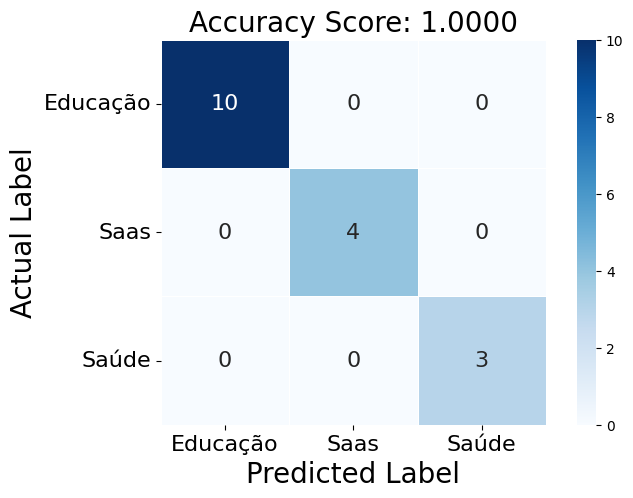

In [35]:
# best_estimator_score = best_estimator.score(X=best_indices_test_X, y=best_indices_test_Y)
best_estimator_score = accuracy_score(y_true=df_y, y_pred=labels_predictions)
best_estimator_score_f1 = f1_score(y_true=df_y, y_pred=labels_predictions, average="weighted")

best_estimator_cmatrix = confusion_matrix(y_pred=labels_predictions, y_true=df_y)
best_estimator_creport = classification_report(y_pred=labels_predictions, y_true=df_y, zero_division=0, output_dict=True)

print(f"F1-Score: {round(best_estimator_score_f1, 4)}")
report(best_estimator_score, best_estimator_cmatrix, best_estimator_creport, classes)

In [36]:
save_features(cv_tfidf_vectorizer, mean_vector_by_segment)

# Test

In [37]:
test_df = pd.read_parquet("../data/iugu_enrichment.parquet", engine="pyarrow")
test_df["html"] = test_df["html"].astype(str)
test_df["raiz_cnpj"] = test_df["raiz_cnpj"].astype(int)
test_df.head(5)

,host,url,html,date,raiz_cnpj,cnpj,Nome da empresa
0,strivio.com.br,https://www.strivio.com.br,b'<!doctype html>\r\n<!-- \xe2\x9c\xa8 Built w...,2025-04-29T18:20:02.060692,54144380,54144380000167,STRIVIO TECNOLOGIA LTDA
1,amentoriaenem.com.br,https://amentoriaenem.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>...",2025-04-29T18:20:04.007576,38194415,38194415000116,A MENTORIA ESTRATEGIA EM APROVACAO LTDA
2,agilize.com.br,http://www.agilize.com.br,b'<!DOCTYPE html> <!--[if lt IE 7]> <html lang...,2025-04-29T18:20:04.916881,17187385,17187385000140,AGILIZE TECNOLOGIA
3,clinicorp.com,https://www.clinicorp.com,"b'<!doctype html>\n<html lang=""pt-BR"">\n<head>...",2025-04-29T18:20:04.129692,26831833,26831833000198,CLINICORP
4,hardpaygateway.com.br,https://hardpaygateway.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>...",2025-04-29T18:20:06.763098,56228263,56228263000107,HARDPAY SOLUCOES DE PAGAMENTOS LTDA


In [38]:
test_df = test_df.merge(linkedin_normalizado, on="raiz_cnpj", how="left")
test_df = test_df[["url_x", "host", "html", "raiz_cnpj", "cnpj", "Nome da empresa", "url_y", "sobre", "slogan", "area_atuacao"]]
test_df = test_df.rename(columns={"url_x": "url", "url_y": "linkedin_url"})
test_df

,url,host,html,raiz_cnpj,cnpj,Nome da empresa,linkedin_url,sobre,slogan,area_atuacao
0,https://www.strivio.com.br,strivio.com.br,b'<!doctype html>\r\n<!-- \xe2\x9c\xa8 Built w...,54144380,54144380000167,STRIVIO TECNOLOGIA LTDA,NaN,NaN,NaN,NaN
1,https://amentoriaenem.com.br,amentoriaenem.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>...",38194415,38194415000116,A MENTORIA ESTRATEGIA EM APROVACAO LTDA,NaN,NaN,NaN,NaN
2,http://www.agilize.com.br,agilize.com.br,b'<!DOCTYPE html> <!--[if lt IE 7]> <html lang...,17187385,17187385000140,AGILIZE TECNOLOGIA,linkedin.com/company/agilize,Somos a primeira contabilidade online do Brasi...,Primeira Contabilidade Online do Brasil.,Accounting
3,https://www.clinicorp.com,clinicorp.com,"b'<!doctype html>\n<html lang=""pt-BR"">\n<head>...",26831833,26831833000198,CLINICORP,linkedin.com/company/clinicorp-solutions,Desenvolvemos as melhores ferramentas para fac...,Desenvolvemos soluções inteligentes para a ges...,Atividades dos serviços de tecnologia da infor...
4,https://hardpaygateway.com.br,hardpaygateway.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>...",56228263,56228263000107,HARDPAY SOLUCOES DE PAGAMENTOS LTDA,NaN,NaN,NaN,NaN
5,http://www.vibx.com.br,vibx.com.br,b'',41695748,41695748000133,VIBX SERVICOS EM TECNOLOGIA LTDA,NaN,NaN,NaN,NaN
6,https://followmefranquias.com.br,followmefranquias.com.br,"b'<!DOCTYPE html><html class=""html"" lang=""pt-B...",32846184,32846184000100,FOLLOW ME CURSO DE IDIOMASFRANCHISING LTDA,NaN,NaN,NaN,NaN
7,https://www.associaclub.com.br,associaclub.com.br,"b'<!DOCTYPE html>\n<html lang=""en-US"">\n<head>...",39843980,39843980000120,ASSOCIATEC BRASIL,linkedin.com/company/associatecbrasil,O Associatec é uma plataforma desenvolvida esp...,"Levamos mais gestão, inovação e tecnologia par...",Software Development
8,https://checkoutcartwave.com.br,checkoutcartwave.com.br,"b'<!DOCTYPE html><html lang=""en""><head><meta c...",33207641,33207641000170,CARTWAVE SOLUCOES DIGITAIS LTDA,NaN,NaN,NaN,NaN
9,http://www.principia.net,principia.net,"b'<!DOCTYPE html>\n<html lang=""pt"">\n<head>\n ...",45954282,45954282000102,PRINCIPIA EDUCACAO TECNOLOGIA E SERVICOS LTDA,NaN,NaN,NaN,NaN


In [39]:
test_df.shape

(36, 10)

In [40]:
test_df["host"].nunique()

31

In [41]:
test_df["url"].nunique()

31

In [42]:
test_df.isnull().sum()

url                 0
host                0
html                0
raiz_cnpj           0
cnpj                0
Nome da empresa     0
linkedin_url       17
sobre              19
slogan             22
area_atuacao       17
dtype: int64

In [43]:
test_df = test_df[["host", "url", "html", "sobre", "slogan"]]
test_df = test_df.rename(columns={"Segmento iugu": "segment", "sobre": "about"})
test_df.head()

,host,url,html,about,slogan
0,strivio.com.br,https://www.strivio.com.br,b'<!doctype html>\r\n<!-- \xe2\x9c\xa8 Built w...,NaN,NaN
1,amentoriaenem.com.br,https://amentoriaenem.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>...",NaN,NaN
2,agilize.com.br,http://www.agilize.com.br,b'<!DOCTYPE html> <!--[if lt IE 7]> <html lang...,Somos a primeira contabilidade online do Brasi...,Primeira Contabilidade Online do Brasil.
3,clinicorp.com,https://www.clinicorp.com,"b'<!doctype html>\n<html lang=""pt-BR"">\n<head>...",Desenvolvemos as melhores ferramentas para fac...,Desenvolvemos soluções inteligentes para a ges...
4,hardpaygateway.com.br,https://hardpaygateway.com.br,"b'<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>...",NaN,NaN


In [44]:
test_df = generate_features(test_df)
test_df = test_df.reset_index(drop=True)
test_df.head(40)

,host,url,html_about,html_slogan,html_tokens,tokens
0,strivio.com.br,https://www.strivio.com.br,[],[],"[xadcio, essencial, taxar, ferramenta, faq, en...","[xadcio, essencial, taxar, ferramenta, faq, en..."
1,amentoriaenem.com.br,https://amentoriaenem.com.br,[],[],"[turma, voc, xaa, poder, caminhar, certar, aju...","[turma, voc, xaa, poder, caminhar, certar, aju..."
2,agilize.com.br,http://www.agilize.com.br,"[primeiro, contabilidade, online, brasil, desd...","[primeiro, contabilidade, online, brasil]","[baixar, app, voc, xaa, est, pouco, passo, abr...","[primeiro, contabilidade, online, brasil, desd..."
3,clinicorp.com,https://www.clinicorp.com,"[desenvolver, melhorar, ferramenta, facilitar,...","[desenvolver, solucoes, inteligente, gestao, d...","[contar, xbado, solu, software, odontol, gico,...","[desenvolver, melhorar, ferramenta, facilitar,..."
4,hardpaygateway.com.br,https://hardpaygateway.com.br,[],[],"[contar, xbado, vantagem, seguran, integrar, s...","[contar, xbado, vantagem, seguran, integrar, s..."
5,vibx.com.br,http://www.vibx.com.br,[],[],[],[]
6,followmefranquias.com.br,https://followmefranquias.com.br,[],[],"[contar, xbado, follow, franquiar, menu, follo...","[contar, xbado, follow, franquiar, menu, follo..."
7,associaclub.com.br,https://www.associaclub.com.br,"[associatec, plataforma, desenvolvido, especif...","[levar, gestao, inovacao, tecnologia, associac...","[associar, clube, xbade, ace, xadvel, voc, xaa...","[associatec, plataforma, desenvolvido, especif..."
8,checkoutcartwave.com.br,https://checkoutcartwave.com.br,[],[],"[xadcio, plano, contato, tutorial, começar, ve...","[xadcio, plano, contato, tutorial, começar, ve..."
9,principia.net,http://www.principia.net,[],[],"[ntop, page, empresar, instituir, ensinar, sup...","[ntop, page, empresar, instituir, ensinar, sup..."


In [45]:
# excluir os que não estão pegando os tokens
test_df['len_tokens'] = test_df['tokens'].apply(len)
test_df = test_df[test_df['len_tokens'] > 0].reset_index(drop=True)
test_df = test_df.drop(columns=['len_tokens'])
test_df.head(30)

,host,url,html_about,html_slogan,html_tokens,tokens
0,strivio.com.br,https://www.strivio.com.br,[],[],"[xadcio, essencial, taxar, ferramenta, faq, en...","[xadcio, essencial, taxar, ferramenta, faq, en..."
1,amentoriaenem.com.br,https://amentoriaenem.com.br,[],[],"[turma, voc, xaa, poder, caminhar, certar, aju...","[turma, voc, xaa, poder, caminhar, certar, aju..."
2,agilize.com.br,http://www.agilize.com.br,"[primeiro, contabilidade, online, brasil, desd...","[primeiro, contabilidade, online, brasil]","[baixar, app, voc, xaa, est, pouco, passo, abr...","[primeiro, contabilidade, online, brasil, desd..."
3,clinicorp.com,https://www.clinicorp.com,"[desenvolver, melhorar, ferramenta, facilitar,...","[desenvolver, solucoes, inteligente, gestao, d...","[contar, xbado, solu, software, odontol, gico,...","[desenvolver, melhorar, ferramenta, facilitar,..."
4,hardpaygateway.com.br,https://hardpaygateway.com.br,[],[],"[contar, xbado, vantagem, seguran, integrar, s...","[contar, xbado, vantagem, seguran, integrar, s..."
5,followmefranquias.com.br,https://followmefranquias.com.br,[],[],"[contar, xbado, follow, franquiar, menu, follo...","[contar, xbado, follow, franquiar, menu, follo..."
6,associaclub.com.br,https://www.associaclub.com.br,"[associatec, plataforma, desenvolvido, especif...","[levar, gestao, inovacao, tecnologia, associac...","[associar, clube, xbade, ace, xadvel, voc, xaa...","[associatec, plataforma, desenvolvido, especif..."
7,checkoutcartwave.com.br,https://checkoutcartwave.com.br,[],[],"[xadcio, plano, contato, tutorial, começar, ve...","[xadcio, plano, contato, tutorial, começar, ve..."
8,principia.net,http://www.principia.net,[],[],"[ntop, page, empresar, instituir, ensinar, sup...","[ntop, page, empresar, instituir, ensinar, sup..."
9,edunext.com.br,http://www.edunext.com.br,[],[],"[sobrar, solu, diferenciar, solu, blog, news, ...","[sobrar, solu, diferenciar, solu, blog, news, ..."


In [46]:
vectorizer_path = "../models/VECTORIZER_v1_iugu_tfidf_similarity_1000_iugu_base.pkl"
embeddings_path = "../models/EMBEDDINGS_v1_iugu_tfidf_similarity_1000_iugu_base.pkl"

with open(vectorizer_path, "rb") as f:
    vectorizer = pickle.load(f)

with open(embeddings_path, "rb") as f:
    embeddings = pickle.load(f)

In [47]:
token_strings = [' '.join(doc) for doc in test_df['tokens']]
tfidf_matrix = vectorizer.transform(token_strings)

# Converter a matriz TF-IDF em um dataframe pandas
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df

abrir      acad   academy   aceitar   acessar    acesse  \
0   0.109317  0.000000  0.000000  0.026760  0.000000  0.000000   
1   0.021021  0.051458  0.117863  0.000000  0.000000  0.019341   
2   0.067408  0.000000  0.000000  0.000000  0.000000  0.035440   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.033513   
5   0.091535  0.000000  0.000000  0.112035  0.025122  0.000000   
6   0.000000  0.000000  0.000000  0.000000  0.056654  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.132309  0.110885   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.044670  0.000000  0.044670  0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.116366  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
17  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
18  0.000000  0.244359  0.000000  0.000000  0.000000  0.000000   
19  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
20  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
21  0.000000  0.000000  0.104086  0.000000  0.027173  0.000000   
22  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23  0.000000  0.000000  0.000000  0.052661  0.000000  0.000000   
24  0.000000  0.000000  0.000000  0.000000  0.063017  0.000000   
25  0.000000  0.000000  0.000000  0.000000  0.000000  0.014278   

    acessibilidade    acesso  acompanhamento  acompanhar  acontecer   acordar  \
0         0.030646  0.022829        0.000000    0.056802   0.000000  0.036003   
1         0.000000  0.029266        0.102915    0.031208   0.025729  0.000000   
2         0.000000  0.026813        0.023573    0.014296   0.058931  0.010572   
3         0.000000  0.028315        0.000000    0.000000   0.049786  0.000000   
4         0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
5         0.032077  0.079648        0.000000    0.000000   0.000000  0.000000   
6         0.000000  0.125732        0.000000    0.000000   0.000000  0.000000   
7         0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
8         0.000000  0.000000        0.000000    0.033841   0.000000  0.050049   
9         0.000000  0.000000        0.000000    0.000000   0.044670  0.000000   
10        0.000000  0.000000        0.000000    0.000000   0.014092  0.000000   
11        0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
12        0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
13        0.000000  0.000000        0.000000    0.000000   0.058183  0.000000   
14        0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
15        0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
16        0.000000  0.057042        0.000000    0.000000   0.000000  0.000000   
17        0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
18        0.000000  0.046326        0.162906    0.000000   0.000000  0.000000   
19        0.000000  0.025820        0.045398    0.000000   0.000000  0.000000   
20        0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
21        0.000000  0.051690        0.000000    0.018373   0.000000  0.000000   
22        0.000000  0.000000        0.000000    0.000000   0.000000  0.000000   
23        0.000000  0.014975        0.000000    0.000000   0.000000  0.000000   
24        0.000000  0.000000        0.000000    0.056812   0.000000  0.000000   
25        0.000000  0.010802        0.000000    0.000000   0.000000  0.000000   

          ad   adaptar  adicionar   

In [48]:
embeddings

,abrir,acad,academy,aceitar,acessar,acesse,acessibilidade,acesso,acompanhamento,acompanhar,acontecer,acordar,ad,adaptar,adicionar,adir,administrar,administrativo,administrator,adquirir,adverso,afiliar,afinal,agendar,agora,ainda,ajudar,alcan,algo,algum,alice,alterar,alto,alunar,aluno,ambientar,amento,anal,analisar,andrade,android,ano,antar,antifraude,apenas,api,aplic,aplicar,aplicativo,apneia,apoiar,app,aprender,aprendizado,aprovar,aproveitar,aqui,arcar,artificial,artigo,assim,assinante,assinar,assinatura,assistir,associar,atender,atendimento,ater,atingir,atividade,atividades,ativo,ativos,atrav,atua,aula,aumentar,autom,automa,automaticamente,automatizar,autorizar,auxiliar,avaliar,avan,avenida,bados,baixar,banc,banco,base,basto,bem,benef,bilh,biologix,blog,boletar,boleto,bom,book,brasil,brasileiro,brunetta,brunir,bump,buscar,caber,cada,cadastrar,caixa,camila,caminhar,campo,canal,captar,cargo,cart,casar,cash,categoria,celular,cen,central,centrar,cep,cerqueiro,certificar,chat,checkout,chegar,ciar,cibern,cidade,cient,cil,cio,circular,claro,clicar,cliente,clip,clipescola,clique,close,club,clube,cnico,cnpj,cobran,col,colaborador,colunista,coment,comer,comercial,começar,comiss,compartilhar,completar,comprar,comprometido,compromisso,comprovante,comum,comunicar,comunidade,condir,conectar,conex,conferir,confian,configurar,conformar,conhe,conhecimento,conosco,conquistar,conseguir,construir,consultor,consultoria,consumir,contact,contar,contato,contatos,contratar,controlo,convers,cooky,coordenador,coordenar,coprodu,coprodutor,copyright,corretamente,could,credenciado,crescer,crescimento,criador,criar,crm,cuidar,culin,cultura,cumprir,cursar,curso,custar,custo,dar,dashboard,datar,ddd,decil,dedicar,definir,deixar,demais,demonstrar,den,dentro,depoimento,desafio,descobrir,descomplicar,descontar,desde,desejar,desempenhar,desenvolver,despertar,despesa,dessar,destacar,detalhar,detected,dever,dia,diagn,dica,dico,diferente,dificuldade,digital,digitalizar,digitar,diminuir,dinheiro,direito,diretamente,direto,diretor,discord,dispensar,dispon,disponibilizar,dispor,dispositivo,disso,diversificar,diverso,dividendo,dizer,dor,downsell,dulos,durante,ebitda,economia,economizar,ecossistema,educacao,educacional,educar,educativo,eduzz,efetuar,eficaz,efici,eficiente,elevar,eliminar,elite,emitir,empreendedor,empreendedorismo,empresar,encaixar,encontrar,engajamento,engajar,ensinar,entender,entrar,entregar,entrevisto,enviar,envolvente,equipar,errar,error,escal,escalar,escola,escolar,escolaweb,escolher,esg,espa,espec,especialista,esperar,essencial,est,estilar,estrat,estudante,estudar,etapa,evento,evolu,exame,excel,excelente,exclusivo,existir,experi,explorar,extra,extrato,facebook,facilidade,facilitar,falar,falir,fam,faq,faturamento,fazer,fechar,feirar,feito,ferramenta,ferrari,ferreiro,ficar,fidelidade,finan,financeiro,fixo,focar,following,fomentar,fonte,form,formar,formato,formul,fornecer,frequente,friend,fun,funcion,funcionalidade,funcionar,fundo,futurar,futuro,gamifica,ganhar,garantir,gateway,gente,gerar,gerenciadas,gerenciar,gerencie,gerente,gerir,gest,gestao,gestor,gia,gica,gico,gil,gina,gio,girar,google,gov,gra,graduacao,graduar,grande,gratuitamente,gratuito,grupar,guerra,hist,hoje,home,hor,horar,horizonte,hospedagem,hospedar,hub,humanizar,ideal,ideia,identificar,imobili,impor,importar,imprensar,impressionante,impulsionar,inadimpl,incentivo,incluir,indicador,indicar,infoprodutores,informar,inicial,inovador,inovar,insatisfeito,inscrever,instagram,instalar,instant,institucional,instituicao,instituicoes,instituir,integrar,intelig,inteligente,intelligence,intera,interagir,interatividade,interessar,internacional,interno,interrup,intuitivo,investidor,investimento,investir,ir,isaac,jader,jogar,jonas,jorge,jornada,josi,juntamente,juntar,junto,juro,kaz,kit,konkol,kotz,kycplda,laborat,lan,landing,lar,last,lastlink,latino,lavagem,lead,legar,legi,levar,liberar,lido,lifestyle,limitar,linha,link,linkedin,liquidar,lise,lista,lit,livre,login,longo,lucrar,lugar,mail,maior,maneiro,

In [49]:
probabilities, labels_predictions = calculate_distances(
    embeddings,
    tfidf_df,
)

In [50]:
y_probs_0, y_probs_1, y_probs_2 = zip(*probabilities)
y_probs_0 = list(y_probs_0)
y_probs_1 = list(y_probs_1)
y_probs_2 = list(y_probs_2)

In [51]:
test_df["prob_Educação"] = y_probs_0
test_df["prob_SaaS"] = y_probs_1
test_df["prob_Saúde"] = y_probs_2
test_df["prediction"] = labels_predictions
test_df

,host,url,html_about,html_slogan,html_tokens,tokens,prob_Educação,prob_SaaS,prob_Saúde,prediction
0,strivio.com.br,https://www.strivio.com.br,[],[],"[xadcio, essencial, taxar, ferramenta, faq, en...","[xadcio, essencial, taxar, ferramenta, faq, en...",0.348737,0.361243,0.290021,Saas
1,amentoriaenem.com.br,https://amentoriaenem.com.br,[],[],"[turma, voc, xaa, poder, caminhar, certar, aju...","[turma, voc, xaa, poder, caminhar, certar, aju...",0.367704,0.319028,0.313268,Educação
2,agilize.com.br,http://www.agilize.com.br,"[primeiro, contabilidade, online, brasil, desd...","[primeiro, contabilidade, online, brasil]","[baixar, app, voc, xaa, est, pouco, passo, abr...","[primeiro, contabilidade, online, brasil, desd...",0.357788,0.347200,0.295012,Educação
3,clinicorp.com,https://www.clinicorp.com,"[desenvolver, melhorar, ferramenta, facilitar,...","[desenvolver, solucoes, inteligente, gestao, d...","[contar, xbado, solu, software, odontol, gico,...","[desenvolver, melhorar, ferramenta, facilitar,...",0.353866,0.331749,0.314385,Educação
4,hardpaygateway.com.br,https://hardpaygateway.com.br,[],[],"[contar, xbado, vantagem, seguran, integrar, s...","[contar, xbado, vantagem, seguran, integrar, s...",0.335202,0.372298,0.292500,Saas
5,followmefranquias.com.br,https://followmefranquias.com.br,[],[],"[contar, xbado, follow, franquiar, menu, follo...","[contar, xbado, follow, franquiar, menu, follo...",0.359917,0.331274,0.308809,Educação
6,associaclub.com.br,https://www.associaclub.com.br,"[associatec, plataforma, desenvolvido, especif...","[levar, gestao, inovacao, tecnologia, associac...","[associar, clube, xbade, ace, xadvel, voc, xaa...","[associatec, plataforma, desenvolvido, especif...",0.345154,0.326712,0.328134,Educação
7,checkoutcartwave.com.br,https://checkoutcartwave.com.br,[],[],"[xadcio, plano, contato, tutorial, começar, ve...","[xadcio, plano, contato, tutorial, começar, ve...",0.352617,0.347062,0.300320,Educação
8,principia.net,http://www.principia.net,[],[],"[ntop, page, empresar, instituir, ensinar, sup...","[ntop, page, empresar, instituir, ensinar, sup...",0.378423,0.315305,0.306272,Educação
9,edunext.com.br,http://www.edunext.com.br,[],[],"[sobrar, solu, diferenciar, solu, blog, news, ...","[sobrar, solu, diferenciar, solu, blog, news, ...",0.362844,0.334226,0.302930,Educação
